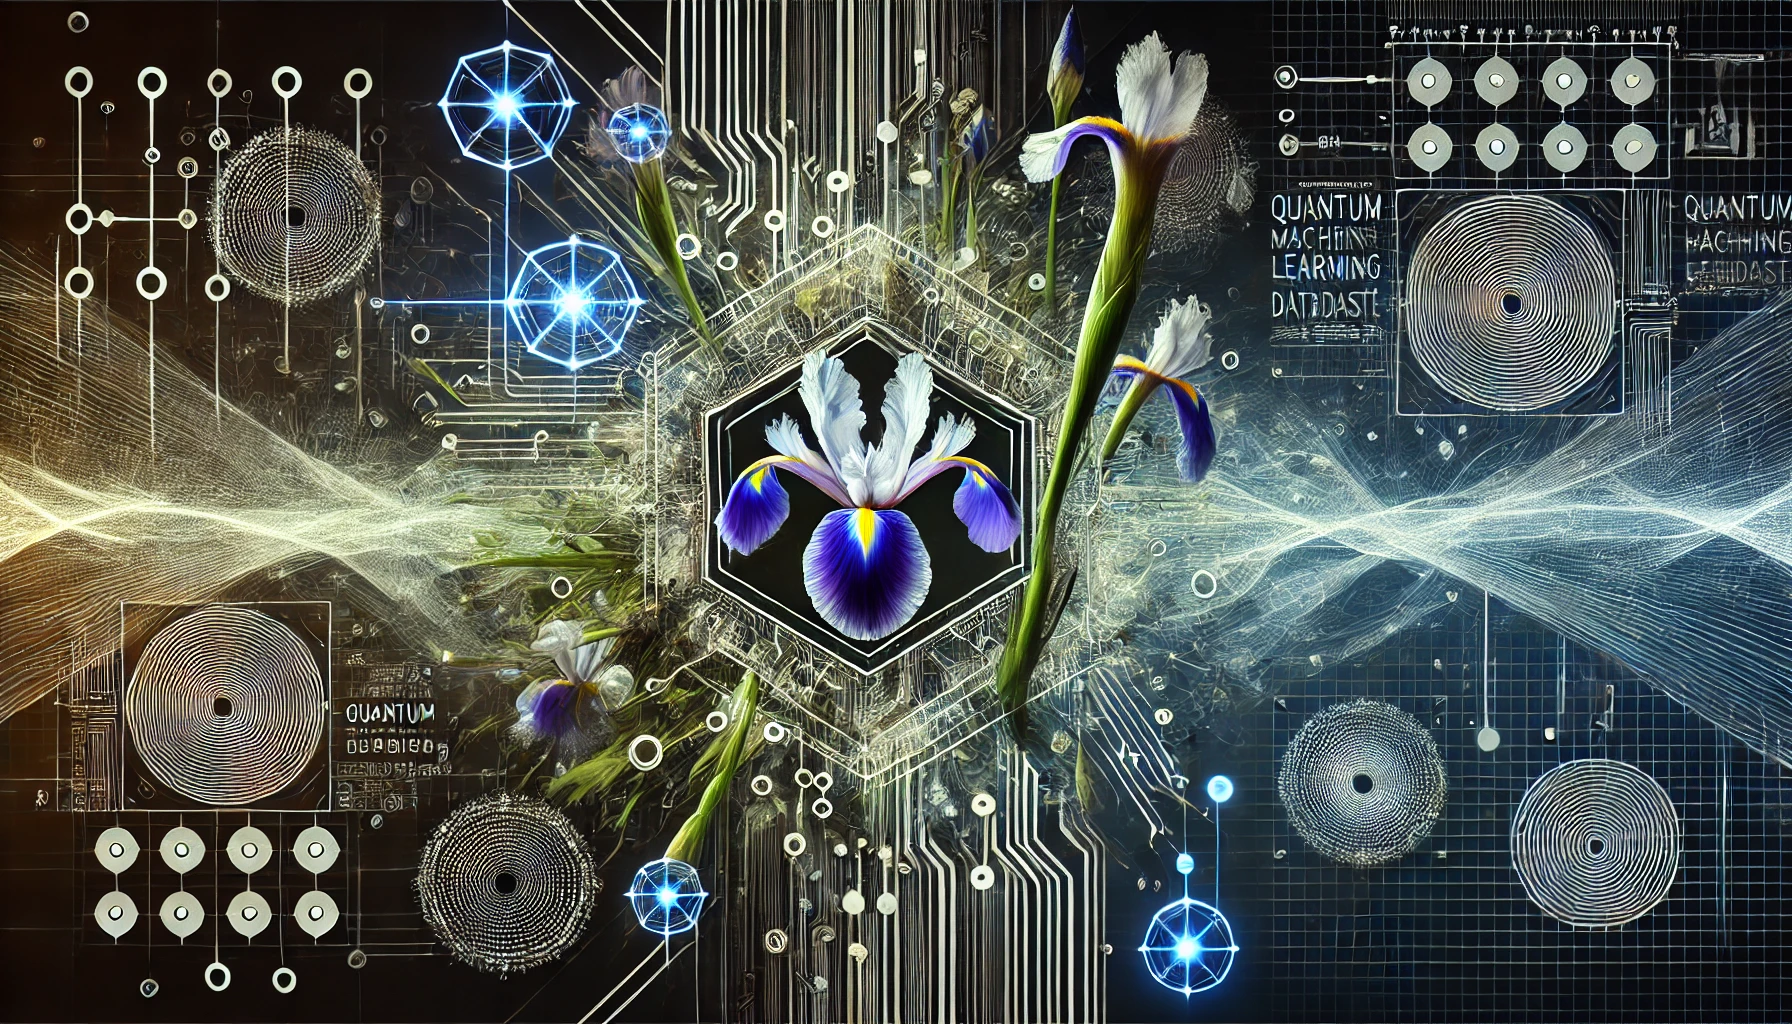

# Quantum Model on a Iris Dataset

This tutorial will demonstrate how to train a quantum machine learning model to tackle a classification problem. Previous tutorials have featured small, artificial datasets. Here we will increase the problem complexity by considering a real-life classical dataset. We decided to pick a very well-known – albeit still relatively small – problem: the Iris flower dataset. This dataset even has its own Wikipedia [page](https://en.wikipedia.org/wiki/Iris_flower_data_set). Although the Iris dataset is well known to data scientists, we will briefly introduce it to refresh our memories. For comparison, we'll first train a classical counterpart to the quantum model.

So, let's get started:

- First, we'll load the dataset and explore what it looks like.
- Next, we'll train a classical model using [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from [scikit-learn](https://scikit-learn.org/) to see how well the classification problem can be solved using classical methods.
- After that, we'll introduce the **Variational Quantum Classifier (VQC)**.
- To conclude, we'll compare the results obtained from both models.

In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_machine_learning

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 49.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 30.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.

# Load the Dataset

In [ ]:
from sklearn.datasets import load_iris # import the iris dataset

iris_data = load_iris()

If no parameters are specified in the `load_iris` function, then a dictionary-like object is returned by scikit-learn. Let's print the description of the dataset and see what is inside.

In [ ]:
print(iris_data.DESCR) # print the description of the dataset

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

There are a few interesting observations we can find from this dataset description:

- There are 150 samples (instances) in the dataset.
- There are four features (attributes) in each sample.
- There are three labels (classes) in the dataset.
- The dataset is perfectly balanced, as there are the same number of samples (50) in each class.
- We can see features are not normalized, and their value ranges are different, e.g., $[4.3, 7.9]$ and $[0.1, 2.5]$ for sepal length and petal width, respectively. So, transforming the features to the same scale may be helpful.
- As stated in the table above, feature-to-class correlation in some cases is very high; this may lead us to think that our model should cope well with the dataset.

We only examined the dataset description, but additional properties are available in the `iris_data` object. Now we are going to work with features and labels from the dataset.

## Exploratory Data Analysis

In [ ]:
#get the features and labels of the dataset
features = iris_data.data
labels = iris_data.target

Firstly, we'll normalize the features. Namely, we will apply a simple transformation to represent all features on the same scale. In our case, we squeeze all features onto the interval $[0, 1]$. Normalization is a common technique in machine learning and often leads to better numerical stability and convergence of an algorithm.

We can use `MinMaxScaler` from scikit-learn to perform this. Without specifying parameters, this does exactly what is required: maps data onto $[0, 1]$.

In [ ]:
from sklearn.preprocessing import MinMaxScaler # import the MinMaxScaler for scaling the features

features = MinMaxScaler().fit_transform(features)

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Let's see how our data looks. We plot the features pair-wise to see if there's an observable correlation between them.

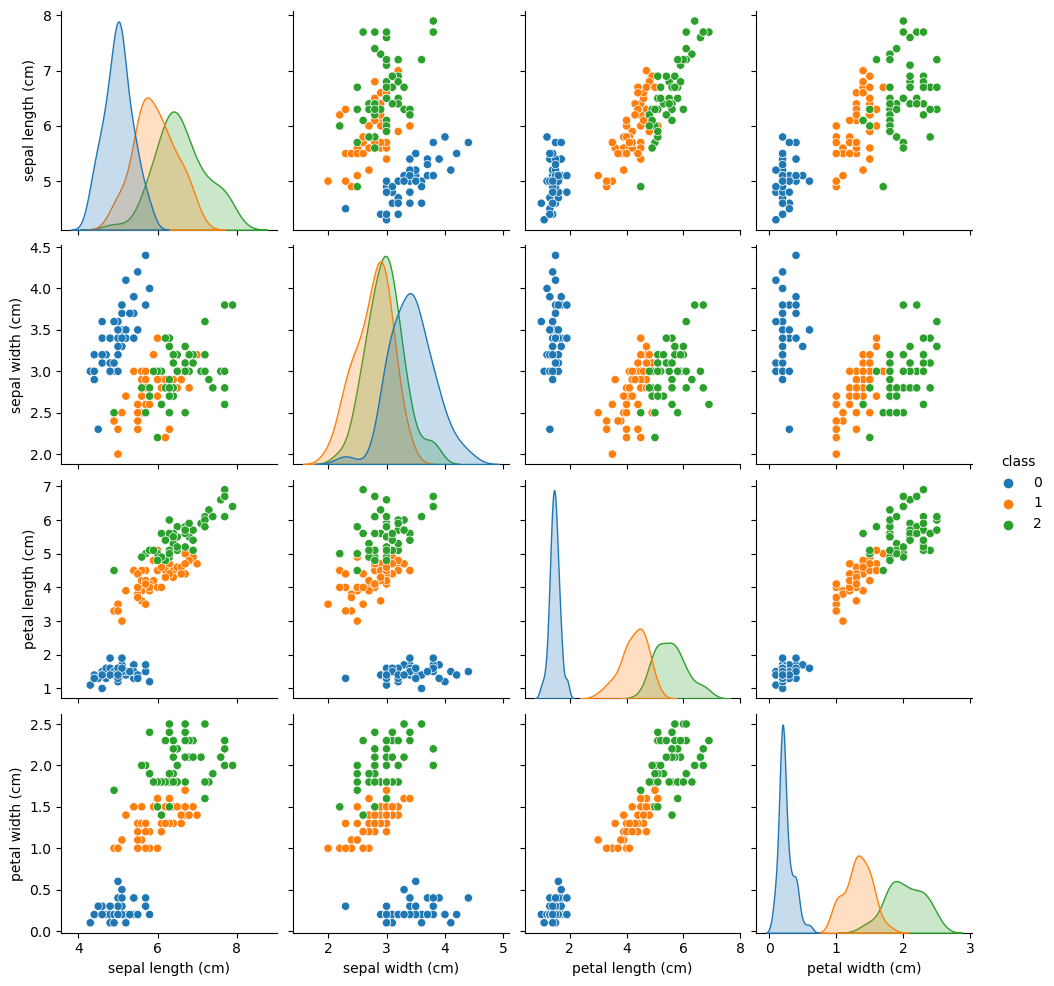

In [ ]:
import matplotlib.pyplot as plt

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

This plot is a **pairplot** from the Seaborn library, which visualizes the relationships between multiple features in a dataset. It is typically used for exploratory data analysis. The plot displays data from the famous **Iris dataset**, where different species of iris flowers are classified into three classes (class 0, class 1, and class 2).

***Breakdown of the plot***

1. **Diagonal plots (Density plots or KDE plots)**:
   - The diagonal plots show the **distribution of each feature** (e.g., sepal length, sepal width, petal length, petal width) for each class (0, 1, 2). The distributions are separated by color, representing the different classes.
   - **Class 0** (blue), **Class 1** (orange), and **Class 2** (green) show distinct distribution patterns, especially for petal length and petal width.

2. **Off-diagonal scatterplots**:
   - The off-diagonal scatterplots show pairwise relationships between the features. For instance, the relationship between **sepal length** and **petal length**, or **sepal width** and **petal width**.
   - Each point represents an individual observation, and the color denotes its class (0, 1, or 2).
   - Clear separation between classes is visible in certain relationships, particularly between **petal length vs. petal width** and **sepal length vs. petal length**.

3. **Class Separation**:
   - In many plots, you can see clear separation between **Class 0** (blue) and the other two classes (orange and green), especially in features related to **petal size**.
   - Classes **1** (orange) and **2** (green) have some overlap in certain feature pairs, but overall, there is discernible clustering.

This pairplot helps in identifying which features best separate the iris species and highlights the relationships between feature pairs.

From the plots, we see that class `0` is easily separable from the other two classes, while classes `1` and `2` are sometimes intertwined, especially regarding the `sepal width` feature.

Next, let's see how classical machine learning handles this dataset.

## Training a Classical Machine Learning Model

Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. We'll use the former to train the model and the latter to verify how well our models perform on unseen data.

As usual, we'll ask scikit-learn to do the boring job for us. We'll also fix the seed to ensure the results are reproducible.

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                            labels,
                                                                            train_size=0.8,
                                                                            random_state = algorithm_globals.random_seed)

### Support Vector Classifier

We train a classical **Support Vector Classifier** from scikit-learn. For the sake of simplicity, we don't tweak any parameters and rely on the default values.

In [ ]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)

Now we check out how well our classical model performs. We will analyze the scores in the conclusion section.

In [ ]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


As can be seen from the scores, the classical **SVC algorithm performs very well**. Next up, it's time to look at quantum machine learning models.

## Training a Quantum Machine Learning Model

As an example of a quantum model, we'll train a **variational quantum classifier (VQC)**. The VQC is the simplest classifier available in Qiskit Machine Learning and is a good starting point for newcomers to quantum machine learning who have a background in classical machine learning.

But before we train a model, let's examine what comprises the `VQC` class. Two of its central elements are the feature map and ansatz. What these are will now be explained.

Our data is classical, meaning it consists of a set of bits, not qubits. We need a way to encode the data as qubits. This process is crucial if we want to obtain an effective quantum model. We usually refer to this mapping as data encoding, data embedding, or data loading and this is the role of the feature map. While feature mapping is a common ML mechanism, this process of loading data into quantum states does not appear in classical machine learning as that only operates in the classical world.

Once the data is loaded, we must immediately apply a parameterized quantum circuit. This circuit is a direct analog to the layers in classical neural networks. It has a set of tunable parameters or weights. The weights are optimized such that they minimize an objective function. This objective function characterizes the distance between the predictions and known labeled data. A parameterized quantum circuit is also called a parameterized trial state, variational form, or ansatz. Perhaps, the latter is the most widely used term.

For more information, we direct the reader to the [Quantum Machine Learning Course](https://learn.qiskit.org/course/machine-learning).

Our choice of feature map will be the ``ZZFeatureMap``. The ``ZZFeatureMap`` is one of the standard feature maps in the Qiskit circuit library. We pass `num_features` as `feature_dimension`, meaning the feature map will have `num_features` or `4` qubits.

We decompose the feature map into its constituent gates to give the reader a flavor of how feature maps may look.

### ZZ Feature Map

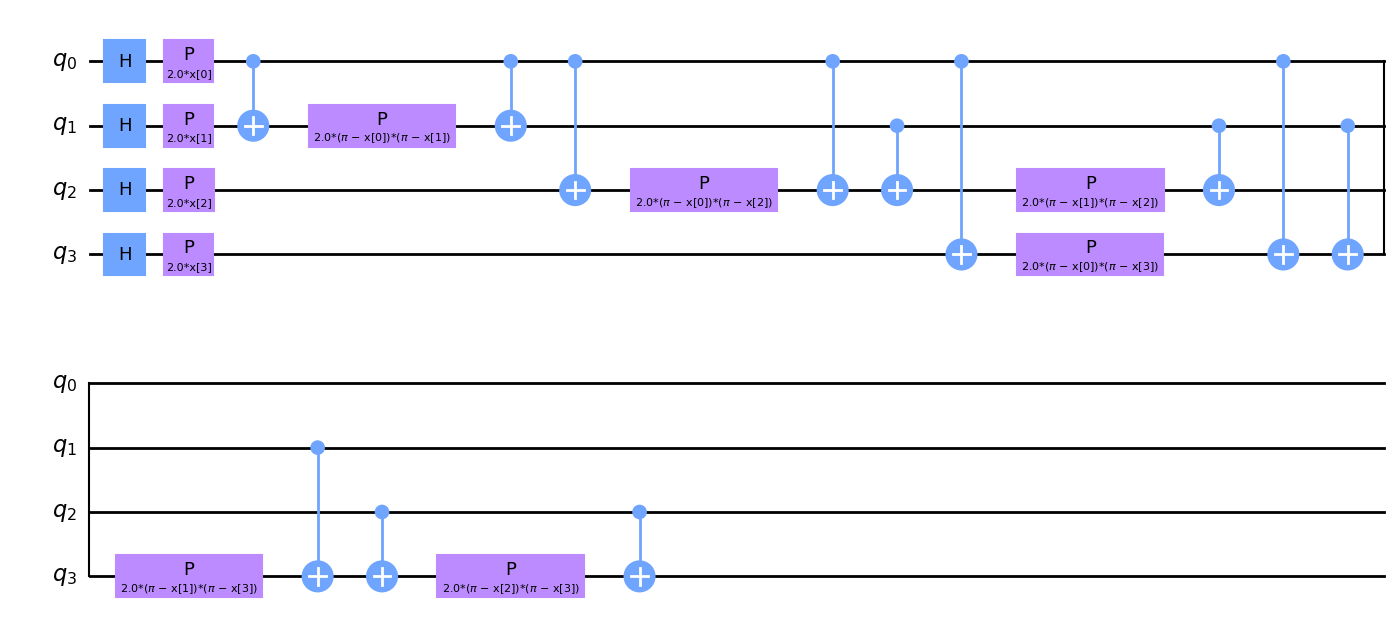

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

# create the feature map for the quantum model
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

This image shows a **quantum circuit** built using a quantum computing framework **Qiskit**.

***Circuit Components***

1. **Quantum Registers (q0, q1, q2, q3)**:
   - These represent qubits, the fundamental units of quantum information. The circuit has four qubits, labeled from **q0** to **q3**.

2. **Hadamard Gates (H)**:
   - The blue boxes labeled "H" are **Hadamard gates**, which place qubits into a superposition state, equally likely to be measured as 0 or 1.
   - In the circuit, each qubit (q0, q1, q2, q3) starts with a Hadamard gate applied, putting all qubits in superposition.

3. **Phase Gates (P)**:
   - The purple boxes labeled **P** represent phase gates. The phase gate applies a phase shift to the qubit’s state based on the input value `x[i]`.
   - The equation inside the gate shows a variable **P = 2.0 * (π − x[0]...x[3])**, indicating that the phase shift is parameterized by data points `x` (likely representing features from a dataset). This suggests that the quantum circuit is being used for data encoding, likely for a machine learning task.

4. **Controlled Operations (CNOT Gates)**:
   - The vertical lines with blue dots and a cross represent **CNOT gates**, which are controlled NOT operations. These gates are essential for entangling qubits, a key feature in quantum computing.
   - The controlled qubit (the one with the dot) determines whether the NOT gate is applied to the target qubit (the one with the cross). The presence of these gates indicates that qubits are being entangled, an essential feature for leveraging quantum interference.

***Key Insights***

- The first layer of Hadamard gates puts all qubits into superposition.
- Data from the input dataset (likely features of some real dataset) is encoded into the qubits using the phase gates, which apply rotations based on the feature values.
- Controlled operations (CNOT gates) create entanglement between qubits, which is necessary for creating complex quantum states that can be used in quantum algorithms.
- The phase gates apply a conditional rotation to each qubit depending on the input data, which is a common method in **Quantum Machine Learning (QML)** to encode classical data into quantum states.

***Purpose***
Given that this quantum circuit is applied in a Kaggle environment with a real dataset, it is used for a **Quantum Machine Learning model**. The dataset values are encoded into quantum states using parameterized gates, and the circuit might be part of a variational algorithm to optimize parameters for classification or regression tasks.

This is a quantum circuit likely designed for a machine learning problem, where data is encoded using parameterized gates, and qubits are entangled to capture quantum correlations between features, which can later be measured to solve a supervised learning task.

If you look closely at the feature map diagram, you will notice parameters `x[0], ..., x[3]`. These are **placeholders** for our features.

### Ansatz Circuit

Now we create and plot our ansatz. Pay attention to the repetitive structure of the ansatz circuit. We define the number of these repetitions using the `reps` parameter.

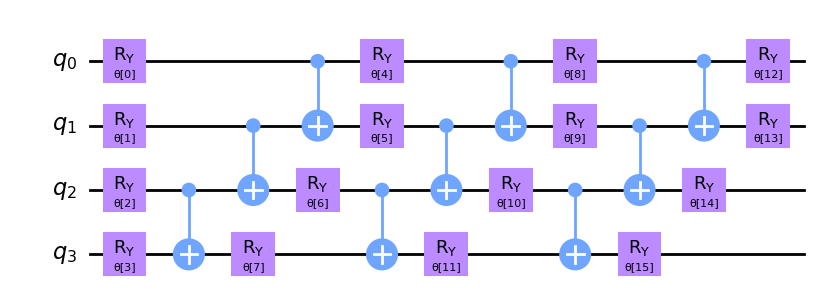

In [ ]:
from qiskit.circuit.library import RealAmplitudes

# create the ansatz for the quantum model
# we use the RealAmplitudes ansatz with 3 repetitions
# and the number of qubits equal to the number of features
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

This plot shows a **quantum circuit** created using the **RealAmplitudes ansatz** from the Qiskit library. This ansatz is commonly used in variational quantum algorithms, especially for quantum machine learning models, such as quantum classifiers or quantum neural networks. Let’s break it down:

***Key Components***

1. **Ansatz Structure (RealAmplitudes)**:
   - The circuit uses the **RealAmplitudes ansatz**, which is a type of parameterized quantum circuit that applies rotations along the Y-axis (using \( R_y \) gates) on the Bloch sphere.
   - This ansatz is used to encode data into the quantum state space and apply trainable parameters to optimize for a specific problem.

2. **Rotational Gates (Ry)**:
   - The purple boxes labeled **R\(_y\)** represent **rotation gates along the Y-axis**. These gates are parameterized by trainable variables, denoted as **θ[0]**, **θ[1]**, etc.
   - The rotation angle is controlled by the parameter **θ**. The circuit has **16 parameters** in total, as seen at the bottom, and these are the tunable weights of the quantum model.
   
3. **Controlled Operations (CNOT Gates)**:
   - The **blue circles with lines** and **plus signs** represent **CNOT (controlled-NOT)** gates. These gates are used to create entanglement between qubits.
   - CNOT gates entangle qubits by applying a NOT operation on the target qubit if the control qubit is in the 1 state, which introduces quantum correlations between qubits.

4. **Qubits (q0, q1, q2, q3)**:
   - The circuit has **four qubits**, denoted as **q0**, **q1**, **q2**, and **q3**. These are the fundamental units of quantum computation in this circuit.
   - The number of qubits corresponds to the number of features in the dataset, implying that the features of the dataset are being encoded into the qubit states using these parameterized gates.

***Key Characteristics of the Circuit***

- **Three repetitions**:
   - The circuit uses 3 layers (repetitions) of **\( R_y \) rotations** and **entanglement (CNOT) gates**, which helps in capturing complex quantum states and correlations between qubits.
   
- **Parameterized Rotation**:
   - Each **\( R_y \)** gate is parameterized, and these parameters (θ values) are the trainable components of the circuit. These values are adjusted during training, much like weights in a classical neural network.

- **Entanglement**:
   - The CNOT gates entangle the qubits, allowing the circuit to explore complex quantum states, which is crucial for quantum machine learning tasks like classification or regression.

***Purpose***

This circuit is likely part of a **Quantum Machine Learning model**, where the dataset’s features are encoded into the qubits using the **\( R_y \)** rotation gates, and the entanglement between qubits (via CNOT gates) allows for the creation of non-linear relationships between features. This kind of model can be used for tasks like classification, with the trainable parameters being optimized to minimize the loss function.


This quantum circuit uses the **RealAmplitudes ansatz** to encode classical data into quantum states, applying three layers of rotations and entanglement. The 16 trainable parameters will be optimized during training to find the best model for the task (e.g., classification or regression on a real dataset).

This circuit has **16 parameters** named `θ[0], ..., θ[15]`. These are the trainable weights of the classifier.

### COBYLA Optimizer

We then choose an optimization algorithm to use in the training process. This step is similar to what one may find in classical deep learning frameworks. To make the training process faster, we choose a gradient-free optimizer. You may explore other optimizers available in Qiskit.
- create the optimizer for the quantum model
- we use the COBYLA optimizer with 100 iterations
- a tolerance of 0.0001

In [ ]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

### Qiskit Aer Statevector Simulator as Default Sampler

In the next step, we define where to train our classifier. We can train on a simulator or a real quantum computer. Here, we will use a simulator. We create an instance of the `Sampler` primitive. This is the reference implementation that is statevector based. Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [ ]:
from qiskit.primitives import Sampler

sampler = Sampler()

### Callback Graph

We will add a callback function called `callback_graph`. `VQC` will call this function for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. The callback will update the plot at each iteration. Note that one can do whatever he/she wants inside a callback function, so long as it has the two-parameter signature we mentioned above.

In [ ]:
from IPython.display import clear_output

objective_func_vals = []

In [ ]:
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it.

`VQC` stands for "variational quantum classifier." It takes a feature map and an ansatz and constructs a quantum neural network automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. You may omit the `sampler` parameter, in this case a `Sampler` instance will be created for someone in the way I created it earlier. I created it manually for illustrative purposes only.

- create the quantum model
- I use the VQC classifier with the feature map, ansatz, optimizer, and callback function defined above
- I also set the quantum instance to the default simulator and the initial point to a random vector
- the random seed is set to 123
- the number of training epochs is set to 1 the number of quantum measurements is set to 1

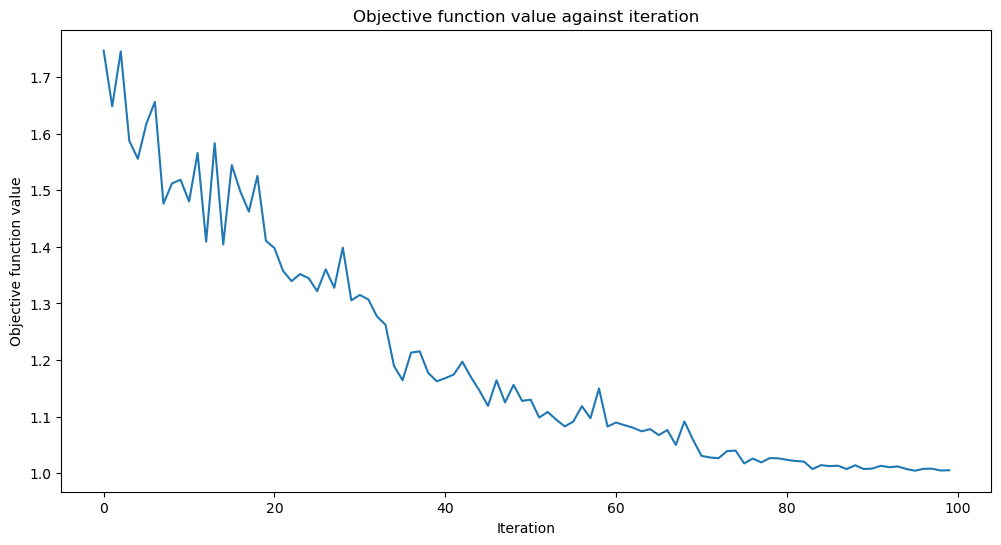

In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(sampler=sampler,
          feature_map=feature_map,
          ansatz=ansatz,
          optimizer=optimizer,
          callback=callback_graph)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

This plot shows the **objective function value** (or loss function) decreasing over **iterations** during the optimization of a quantum machine learning model.

***Explanation***

1. **X-axis (Iteration)**:
   - The horizontal axis represents the **number of iterations** during the training process. Each iteration corresponds to one optimization step where the model's parameters (like the weights in a classical machine learning model) are updated.

2. **Y-axis (Objective function value)**:
   - The vertical axis represents the value of the **objective function** (also called the loss or cost function). This value measures how well the model is performing at a given step.
   - The goal of optimization is to **minimize** this objective function, so a lower value means the model is performing better.

3. **Plot Behavior**:
   - The plot starts with a high objective function value (around 1.7) and gradually decreases as iterations progress.
   - The line shows that the model improves with each iteration as the objective function value **drops sharply** in the beginning and then **smoothly** decreases until it converges (flattens) around 1.1.
   - The fluctuations in the line at the beginning suggest some instability in the optimization process, which is common early in training, but it becomes more stable as the process continues.

***Interpretation***
- This plot indicates that the **quantum model** is being trained using an optimization algorithm, such as a **variational quantum algorithm** (e.g., VQE or QAOA), where parameters of the quantum circuit are being adjusted to minimize the objective function.
- The decreasing trend shows successful training, with the model's performance improving over time. Eventually, it reaches convergence as the objective function stabilizes, implying that further iterations do not significantly improve the model.

This plot illustrates the successful training of a quantum machine learning model, where the objective function value is minimized as the number of iterations increases, leading to a more optimal model.

In [ ]:
print(f"Training time: {round(elapsed)} seconds")

Training time: 152 seconds


Let's see how the quantum model performs on the real-life dataset.

### Validation Score

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

# print the scores of the quantum model
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87


**As we can see, the scores are high, and the model can be used to predict labels on unseen data.**

# Comparison



Now let's see what we can tune to get even better models.

- The key components are the feature map and the ansatz. You can tweak parameters. In our case, you may change the `reps` parameter that specifies how repetitions of a gate pattern we add to the circuit. Larger values lead to more entanglement operations and more parameters. Thus, the model can be more flexible, but the higher number of parameters also adds complexity, and training such a model usually takes more time. Furthermore, we may end up overfitting the model. You can try the other feature maps and ansatzes available in the [Qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits), or you can come up with custom circuits.
- You may try other optimizers. Qiskit contains a bunch of them. Some of them are gradient-free, others not. If you choose a gradient-based optimizer, e.g., `L_BFGS_B`, expect the training time to increase. Additionally to the objective function, these optimizers must evaluate the gradient with respect to the training parameters, which leads to an increased number of circuit executions per iteration.
- Another option is to randomly (or deterministically) sample `initial_point` and fit the model several times.

But what if a dataset contains more features than a modern quantum computer can handle? Recall, in this example, we had the same number of qubits as the number of features in the dataset, but this may not always be the case.

## Reducing the Number of Features

In this section, we reduce the number of features in our dataset and train our models again. We'll move through faster this time as the steps are the same except for the first, where we apply a PCA transformation.

We transform our four features into two features only. This dimensionality reduction is for educational purposes only. As you saw in the previous section, we can train a quantum model using all four features from the dataset.

Now, we can easily plot these two features on a single figure.

<AxesSubplot:>

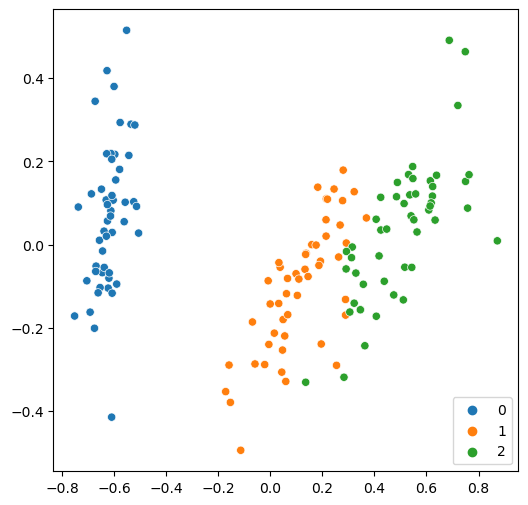

In [ ]:
from sklearn.decomposition import PCA

# reduce the dimensionality of the features to 2
features = PCA(n_components=2).fit_transform(features)

# plot the data using seaborn with the labels as the hue
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

This plot is a **scatter plot** generated after reducing the dimensionality of a dataset using **PCA (Principal Component Analysis)**. Let’s break it down:

***Key Components***

1. **Dimensionality Reduction with PCA**:
   - The dataset, which originally had higher dimensions (features), has been reduced to **two principal components** using PCA. This is a common technique in data visualization to project high-dimensional data onto a 2D plane while retaining as much variance (information) as possible.
   - The **two principal components** represent the directions in which the data varies the most.

2. **Data Points**:
   - Each dot on the plot represents a data point in the reduced 2D feature space.
   - The position of each point is determined by its value along the two principal components (PC1 and PC2).

3. **Labels (Hue)**:
   - The color of the points represents different **classes** or **labels** in the dataset.
   - The plot uses three classes, as indicated by the legend:
     - **Class 0 (blue)**
     - **Class 1 (orange)**
     - **Class 2 (green)**
   - The `hue=labels` parameter maps each data point to a specific class, which helps in visually distinguishing between the classes.

4. **Clusters and Separation**:
   - **Class 0 (blue)**: The blue points form a well-separated cluster on the left side of the plot, indicating that this class is easily distinguishable from the other two.
   - **Class 1 (orange)** and **Class 2 (green)**: There is some overlap between these two classes, suggesting that they are more similar to each other in this reduced space and may be harder to classify compared to Class 0.

***Purpose of PCA***
- PCA is used here to **reduce the dimensionality** of the features while retaining most of the data’s variance. This helps in **visualizing** the data in a 2D space, which is much easier to interpret.
  
***Insights***
- **Class 0** is well-separated, indicating that it may be easier to classify.
- **Class 1 and Class 2** overlap, which could present challenges for classification, possibly requiring more complex decision boundaries in a classification task.

As usual, we split the dataset first, then fit a classical model.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                            labels,
                                                                            train_size=0.8,
                                                                            random_state=algorithm_globals.random_seed)

# create the feature map for the quantum model
svc.fit(train_features, train_labels)

SVC()

In [ ]:
train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


The results are still good but **slightly worse compared to the initial version**.

Let's see how a quantum model deals with them. As we now have two qubits, we must recreate the feature map and ansatz.

In [ ]:
num_features = features.shape[1]

# create the feature map for the quantum model
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

We also reduce the maximum number of iterations we run the optimization process for, as we expect it to converge faster because we now have fewer qubits.

In [ ]:
optimizer = COBYLA(maxiter=40)

Now we construct a quantum classifier from the new parameters and train it.

- create the sampler for the quantum model
- we use the default sampler which is the Qiskit Aer Statevector Simulator with 1000 shots and a seed of 123

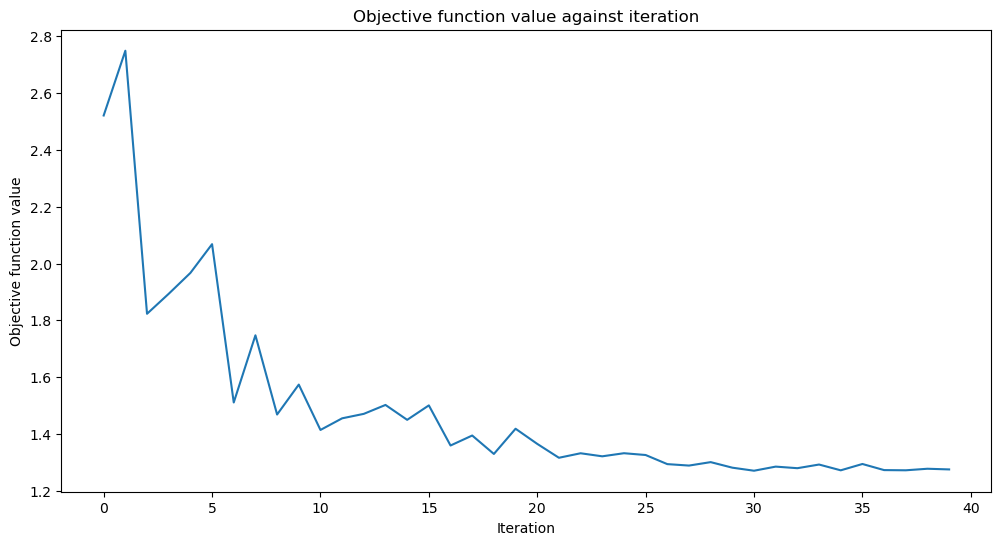

In [ ]:
vqc = VQC(sampler=sampler,
          feature_map=feature_map,
          ansatz=ansatz,
          optimizer=optimizer,
          callback=callback_graph)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

This plot shows the **objective function value** (or loss function) plotted against the number of **iterations** during the optimization process of a quantum machine learning model.

***Explanation***

1. **X-axis (Iteration)**:
   - The horizontal axis represents the number of **iterations**, where each iteration corresponds to an optimization step during the training process. Each iteration updates the model's parameters in an attempt to minimize the objective function.

2. **Y-axis (Objective Function Value)**:
   - The vertical axis represents the **objective function value**, which measures how well the model is performing at a particular iteration. The goal is to **minimize** this value, as lower objective function values indicate better model performance.

3. **Plot Behavior**:
   - The objective function starts with a relatively high value, peaking around **2.6** in the early iterations.
   - Over time, as the model is trained, the objective function value **decreases rapidly** during the first few iterations, showing significant improvement in model performance.
   - After around 10-15 iterations, the objective function continues to decrease but at a slower rate, eventually converging around **1.4** after approximately 35 iterations. This indicates that the model has **stabilized** and is not improving much with further iterations.

***Interpretation***

- The model is being **optimized** over time, and the decreasing objective function value suggests that the training is progressing as expected.
- The sharp decrease at the beginning indicates rapid learning, while the flattening of the curve suggests that the model has reached a point where further improvements are minimal (i.e., it is close to convergence).
- This plot is typical in optimization algorithms, where early iterations bring significant improvements, and later iterations focus on fine-tuning.


The plot indicates successful training, as the objective function value consistently decreases with iterations. The model reaches **convergence** around iteration 35, showing that **further optimization does not lead to significant improvement in performance**.

In [ ]:
print(f"Training time: {round(elapsed)} seconds")

Training time: 32 seconds


In [ ]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.58
Quantum VQC on the test dataset using RealAmplitudes:     0.63


Well, the scores are higher than a fair coin toss but could be better. The objective function is almost flat towards the end, meaning increasing the number of iterations won't help, and model performance will stay the same. Let's see what we can do with another ansatz.

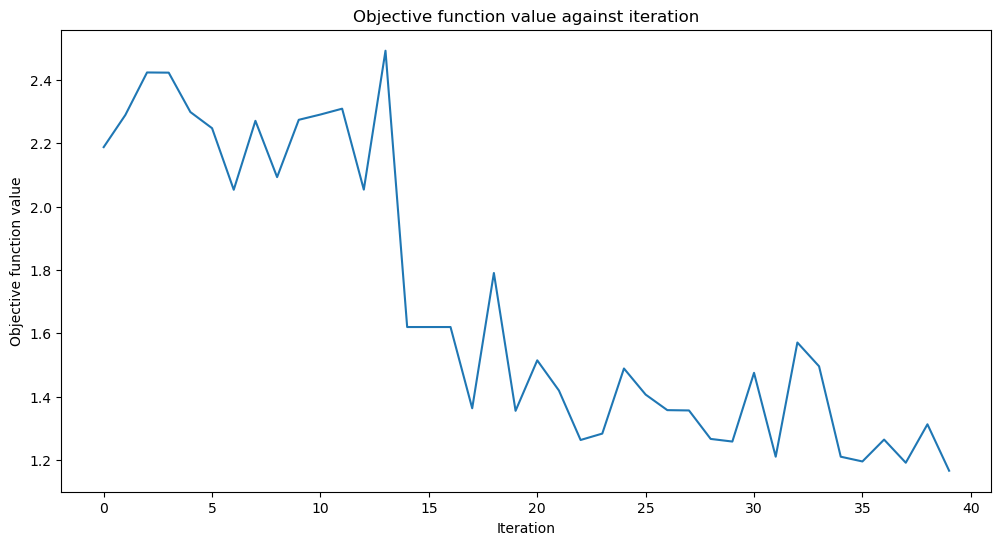

Training time: 40 seconds


In [ ]:
from qiskit.circuit.library import EfficientSU2


ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

This plot displays the **objective function value** (or loss function) against the number of **iterations** during the training of a quantum model.

***Explanation***

1. **X-axis (Iteration)**:
   - The horizontal axis represents the **number of iterations**. Each iteration corresponds to one step of parameter updates during the optimization process.

2. **Y-axis (Objective Function Value)**:
   - The vertical axis represents the **objective function value** (or loss function), which measures how well the model performs at a particular iteration. The objective of the optimization algorithm is to **minimize** this value over time.

3. **Plot Behavior**:
   - The plot starts at a high objective function value, around **2.4**, and exhibits fluctuations for the first few iterations.
   - After around **10 iterations**, there is a significant drop in the objective function value to around **1.7**, indicating that the model is learning and improving rapidly at that stage.
   - The fluctuations continue after the drop, suggesting some instability in the optimization process, but the overall trend is downward, indicating that the model is gradually converging.
   - As the iterations progress, the value approaches a lower range of about **1.3** by iteration 40, showing that the model has made significant progress and is nearing convergence, but is still refining itself with small fluctuations.

***Interpretation***
- The objective function shows a general **decreasing trend** with iterations, indicating that the model is learning and optimizing its parameters to reduce the loss function.
- The **fluctuations** in the early stages (and periodically later) indicate that the optimization process might have some difficulty converging smoothly, but this is expected in quantum optimization problems due to the non-deterministic nature of quantum algorithms.
- After about **15 iterations**, the steep decline in the objective function suggests a breakthrough in learning, likely corresponding to the optimization algorithm finding a more suitable region in the parameter space.
- Despite the fluctuations, the model achieves **convergence** as the objective function value levels out around 1.3 in the final iterations.

This plot indicates that the quantum model is successfully being optimized over time. The objective function value decreases significantly after a few iterations, showing rapid improvement. Although there are fluctuations, the overall downward trend suggests that the model is converging, with the objective function reaching lower values by the end of the optimization process.

In [ ]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.71
Quantum VQC on the test dataset using EfficientSU2:     0.67


The scores are better than in the previous setup. Perhaps if we had used more iterations, we could do even better.

# Conclusion

In this project, we have built two classical and three quantum machine learning models. Let's print an overall table with our results.

In [ ]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.85 |       0.87
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.58 |       0.63
VQC, 2 features, EfficientSU2   |       0.71 |       0.67


This output presents the performance comparison between different machine learning models: **Support Vector Classifier (SVC)** and **Variational Quantum Classifier (VQC)**, with different numbers of features and quantum circuit architectures (RealAmplitudes and EfficientSU2). The scores for both the **test** and **train** sets are provided for each model.

***Key Points***

1. **SVC Models**:
   - **SVC with 4 features** achieves a very high test score of **0.99** and a train score of **0.97**, indicating that it performs exceptionally well both on the training and test data. This model has a good generalization, as the difference between the train and test scores is small.
   - **SVC with 2 features** still performs well, with a test score of **0.97** and a train score of **0.90**. The decrease in performance compared to the 4-feature version is likely due to the loss of important information when reducing the number of features.

2. **VQC Models (Quantum Models)**:
   - **VQC with 4 features, RealAmplitudes ansatz** has a test score of **0.85** and a train score of **0.87**. While the scores are decent, the quantum classifier doesn't perform as well as the classical SVC model. However, the small difference between the train and test scores indicates the model is not overfitting.
   - **VQC with 2 features, RealAmplitudes ansatz** performs significantly worse, with a test score of **0.58** and a train score of **0.63**. This suggests that reducing the features drastically impacts the model's ability to generalize and learn the patterns in the data.
   - **VQC with 2 features, EfficientSU2 ansatz** performs slightly better than the RealAmplitudes version, with a test score of **0.71** and a train score of **0.67**. This indicates that the **EfficientSU2 ansatz** is a better circuit architecture for this particular problem with fewer features, though it still does not match the performance of the classical SVC model.

***Insights***
1. **SVC Models Perform Better**:
   - The classical SVC models consistently outperform the quantum models (VQC) in terms of both test and train scores, especially when using more features.
   
2. **Feature Reduction Hurts VQC Performance**:
   - For the quantum models (VQC), reducing the number of features from 4 to 2 leads to a substantial drop in both test and train scores. This suggests that the quantum models are more sensitive to the number of features used for training.

3. **Quantum Circuit Architecture Matters**:
   - Between the two quantum circuit architectures (RealAmplitudes and EfficientSU2), **EfficientSU2** shows better performance with 2 features. This highlights the importance of selecting the right quantum circuit for a given problem.

The classical **SVC** outperforms the quantum **VQC** in this comparison, especially with more features. The **VQC** models show lower test scores, especially when fewer features are used, and the choice of the quantum circuit ansatz (RealAmplitudes vs. EfficientSU2) affects the model's performance. EfficientSU2 performs better than RealAmplitudes with fewer features, but overall, the quantum models do not yet match the classical SVC in accuracy.

Unsurprisingly, the classical models perform better than their quantum counterparts, but classical ML has come a long way, and quantum ML has yet to reach that level of maturity. As we can see,  we achieved the best results using a classical support vector machine. But the quantum model trained on four features was also quite good. When we reduced the number of features, the performance of all models went down as expected. So, if resources permit training a model on a full-featured dataset without any reduction, you should train such a model. If not, you may expect to compromise between dataset size, training time, and score.

Another observation is that even a simple ansatz change can lead to better results. The two-feature model with the `EfficientSU2` ansatz performs better than the one with `RealAmplitudes`. That means the choice of hyperparameters plays the same critical role in quantum ML as in classical ML, and searching for optimal hyperparameters may take a long time. You may apply the same techniques we use in classical ML, such as random/grid or more sophisticated approaches.